In [1]:
# ==============================================================
# SVM Experiments – LinearSVC
# ==============================================================
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Local project imports
from preprocessing import prepare_data

# Avoid convergence warnings spam
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Experiment config
random_state = 42
results = []
partial_save_path = "results/svm_partial_results.csv"

In [2]:
# ---
# 1. Load Data
# ---
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print("Loaded train/test data.")

Loaded train/test data.


In [3]:
# ---
# 2. Prepare Data for LINEAR Models
# ---
# We MUST use mode="linear". This applies StandardScaler and OneHotEncoder.
# We fit ONCE on the training data.
print("Fitting encoders and scalers on train data...")
out_train_init = prepare_data(
    train_df,
    mode="linear",
    training=False,  # We only need the encoders/scalers
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"] # <-- SVM needs this
print("Fit complete.")

# Prepare TEST set using the *same* "linear" mode and fitted objects
print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

# Clean inf/-inf values (just in case)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for linear models. Shape: {X_test.shape}")

Fitting encoders and scalers on train data...
Fit complete.
Preparing test set...
Test set prepared for linear models. Shape: (555719, 25)


In [4]:
# ---
# 3. Define Experiment Parameters
# ---
# We will test all ratios for this baseline model
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0] 
resample_types_to_test = ["df_up", "df_down"] 

# LinearSVC parameters
params_to_test = [
    {
        "name": "LinearSVC",
        "params": {
            "random_state": random_state,
            "max_iter": 5000 # Increase max_iter to ensure convergence
        },
    }
]

In [5]:
# ---
# 4. Run Experiment Loop
# ---
print("\nStarting LinearSVC experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    # Prepare training data for this *specific ratio*
    # We use fit=False (THE CORRECT WAY)
    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Clean inf/-inf values
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        for p_info in params_to_test:
            model_name = p_info["name"]
            params = p_info["params"]
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} ...", end="")
            sys.stdout.flush()

            model = LinearSVC(**params)
            
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)
            # LinearSVC doesn't have predict_proba, use decision_function for AUC
            y_score = model.decision_function(X_test)

            # Metrics
            f1 = f1_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_score)
            prec = precision_score(y_test, y_pred, zero_division=0)
            acc = accuracy_score(y_test, y_pred)
            
            results.append(
                {
                    "model": model_name,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""),
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                    "roc_auc": auc,
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting LinearSVC experiment loop...

[19:52:12] Starting ratio 1/7 → ratio=None
  [19:52:17] → Training on df_up (samples=1,296,675)
    ⏳ Running LinearSVC ... done → F1=0.0000, Recall=0.0000, AUC=0.8316 | Time=13.9s
  [19:52:32] → Training on df_down (samples=1,296,675)
    ⏳ Running LinearSVC ... done → F1=0.0000, Recall=0.0000, AUC=0.8316 | Time=11.5s
  💾 Saved intermediate results → results/svm_partial_results.csv
  ✅ Completed ratio=None in 0.5 min

[19:52:43] Starting ratio 2/7 → ratio=0.05
  [19:52:48] → Training on df_up (samples=1,353,627)
    ⏳ Running LinearSVC ... done → F1=0.3738, Recall=0.2779, AUC=0.8288 | Time=11.8s
  [19:53:00] → Training on df_down (samples=157,626)
    ⏳ Running LinearSVC ... done → F1=0.3728, Recall=0.2769, AUC=0.8287 | Time=1.4s
  💾 Saved intermediate results → results/svm_partial_results.csv
  ✅ Completed ratio=0.05 in 0.3 min

[19:53:02] Starting ratio 3/7 → ratio=0.1
  [19:53:08] → Training on df_up (samples=1,418,086)
    ⏳ Running LinearSV

In [6]:
# ---
# 5. Show Final Results
# ---
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing LinearSVC Models ---")
print(results_df.head(10))

results_df.to_csv("results/svm_results.csv", index=False)
print("\nSaved final results to results/svm_results.csv")


All ratios completed.
Total experiments logged: 14

--- Top Performing LinearSVC Models ---
        model  ratio resample_type  accuracy  precision    recall        f1  \
2   LinearSVC   0.05            up  0.996406   0.570881  0.277855  0.373785   
3   LinearSVC   0.05          down  0.996403   0.570058  0.276923  0.372764   
4   LinearSVC   0.10            up  0.993990   0.288795  0.380886  0.328508   
5   LinearSVC   0.10          down  0.993882   0.282797  0.380886  0.324593   
7   LinearSVC   0.20          down  0.985653   0.125739  0.456410  0.197160   
6   LinearSVC   0.20            up  0.985561   0.124537  0.454545  0.195508   
8   LinearSVC   0.30            up  0.979468   0.097629  0.524009  0.164592   
9   LinearSVC   0.30          down  0.978966   0.094769  0.520280  0.160333   
11  LinearSVC   0.50          down  0.953462   0.055645  0.692308  0.103011   
10  LinearSVC   0.50            up  0.951855   0.053584  0.688578  0.099431   

     roc_auc  
2   0.828762  
3   0.8


Generating plots...


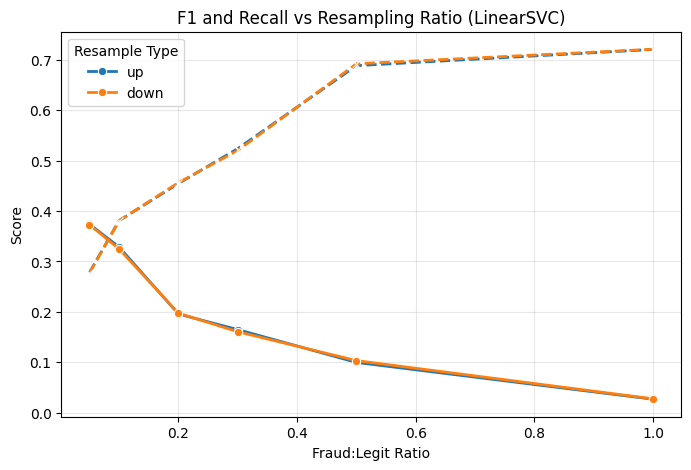

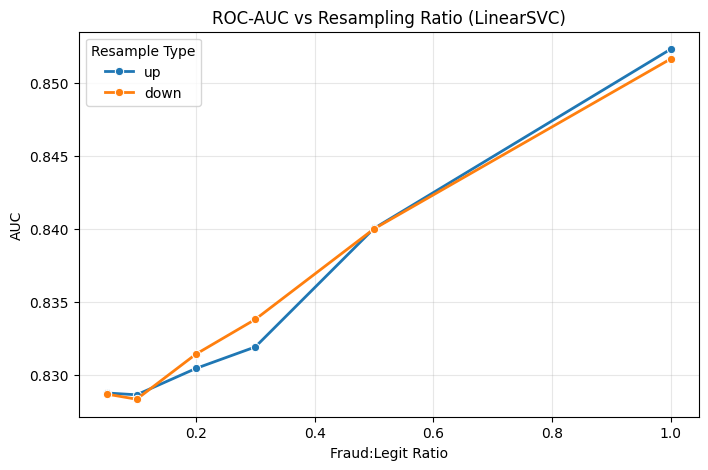


--- Mean Scores Summary ---
                     precision  recall     f1  roc_auc
ratio resample_type                                   
0.05  down               0.570   0.277  0.373    0.829
      up                 0.571   0.278  0.374    0.829
0.10  down               0.283   0.381  0.325    0.828
      up                 0.289   0.381  0.329    0.829
0.20  down               0.126   0.456  0.197    0.831
      up                 0.125   0.455  0.196    0.830
0.30  down               0.095   0.520  0.160    0.834
      up                 0.098   0.524  0.165    0.832
0.50  down               0.056   0.692  0.103    0.840
      up                 0.054   0.689  0.099    0.840
1.00  down               0.014   0.721  0.027    0.852
      up                 0.013   0.721  0.026    0.852

Plots and summary complete.


In [7]:
# ---
# 6. Plot Results
# ---
if not results_df.empty:
    print("\nGenerating plots...")
    
    # ---- Plot F1 & Recall vs Ratio ----
    plt.figure(figsize=(8,5))
    sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type", marker="o", linewidth=2)
    sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type", marker="x", linestyle="--", linewidth=2, legend=False)
    plt.title("F1 and Recall vs Resampling Ratio (LinearSVC)")
    plt.xlabel("Fraud:Legit Ratio")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Resample Type")
    plt.savefig("results/svm_f1_recall_plot.png")
    plt.show()

    # ---- Plot ROC-AUC vs Ratio ----
    plt.figure(figsize=(8,5))
    sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="resample_type", marker="o", linewidth=2)
    plt.title("ROC-AUC vs Resampling Ratio (LinearSVC)")
    plt.xlabel("Fraud:Legit Ratio")
    plt.ylabel("AUC")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Resample Type")
    plt.savefig("results/svm_auc_plot.png")
    plt.show()
    
    # ---- Summary Table ----
    summary = results_df.groupby(["ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
    print("\n--- Mean Scores Summary ---")
    print(summary)

    print("\nPlots and summary complete.")
else:
    print("No results to plot.")